In [8]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy import ndimage
from skimage.color import rgb2gray

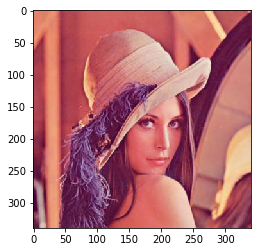

In [126]:
img = io.imread("img.jpg")
plt.imshow(img)
plt.show()

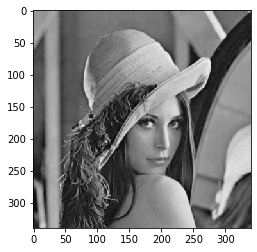

In [127]:
gray_img = rgb2gray(img)
plt.imshow(gray_img, cmap = plt.get_cmap('gray'))
plt.show()

In [128]:
from scipy import signal

def gkern(kernlen=21, std=3):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

# Canny Edge Detector

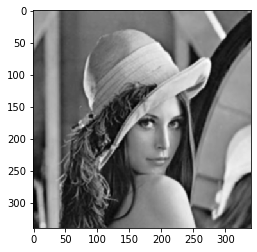

In [129]:
guassian_img = ndimage.convolve(gray_img, gkern(3,3))
plt.imshow(guassian_img, cmap = plt.get_cmap('gray'))
plt.show()

In [130]:
dx = np.array([[-1,0,1],
               [-1,0,1],
               [-1,0,1]])
dy = np.array([[-1,-1,-1],
               [0,0,0],
               [1,1,1]])

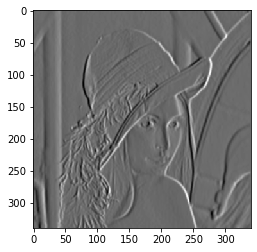

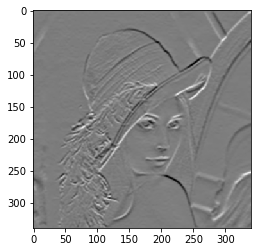

In [131]:
dx_img = ndimage.convolve(guassian_img, dx)
dy_img = ndimage.convolve(guassian_img, dy)
plt.imshow(dx_img, cmap = plt.get_cmap('gray'))
plt.show()
plt.imshow(dy_img, cmap = plt.get_cmap('gray'))
plt.show()

In [24]:
plt.imsave("dx_img.jpg", dx_img, cmap = plt.get_cmap('gray'))
plt.imsave("dy_img.jpg", dy_img, cmap = plt.get_cmap('gray'))

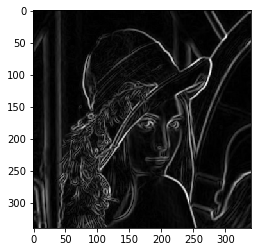

In [132]:
res_img = np.hypot(dx_img,dy_img)
plt.imshow(res_img, cmap = plt.get_cmap('gray'))
plt.show()

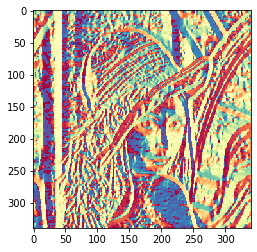

In [148]:
gradient = np.degrees(np.arctan2(dy_img,dx_img))
plt.imshow(gradient, cmap = plt.get_cmap('Spectral'))
plt.show()

In [133]:
def applyThreshold(res_img,threshold=0.3):
    final_img = np.zeros(res_img.shape)
    for x in range(0, res_img.shape[0]):
        for y in range(0, res_img.shape[0]):
            if res_img[x,y]>threshold:
                final_img[x,y]=1
    return final_img
def Normalize(img):
    #img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img
    
mean_mask = np.ones((3,3))
sobel_mask= mean_mask
sobel_mask[:,1]=2
sobel_mask

array([[1., 2., 1.],
       [1., 2., 1.],
       [1., 2., 1.]])

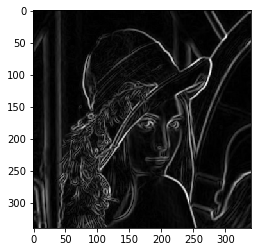

In [134]:
res_img = Normalize(res_img)
plt.imshow(res_img, cmap = plt.get_cmap('gray'))
plt.show()

In [135]:
def NonMaxSup(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

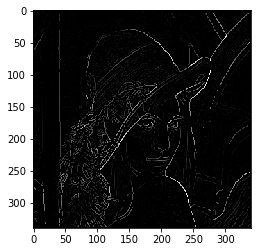

In [139]:
img_nms = NonMaxSup(res_img, gradient)
plt.imshow(img_nms, cmap = plt.get_cmap('gray'))
plt.show()

In [142]:
def DoThreshHyst(img):
    highThresholdRatio =0.32
    lowThresholdRatio = 0.28
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges do not change, i.e all weak edges connected to strong edges have been found
#     while(oldx != x):
#         oldx = x
    for i in range(1,h-1):
        for j in range(1,w-1):
            if(GSup[i,j] > highThreshold):
                GSup[i,j] = 1
            elif(GSup[i,j] < lowThreshold):
                GSup[i,j] = 0
            else:
                if((GSup[i-1,j-1] > highThreshold) or 
                    (GSup[i-1,j] > highThreshold) or
                    (GSup[i-1,j+1] > highThreshold) or
                    (GSup[i,j-1] > highThreshold) or
                    (GSup[i,j+1] > highThreshold) or
                    (GSup[i+1,j-1] > highThreshold) or
                    (GSup[i+1,j] > highThreshold) or
                    (GSup[i+1,j+1] > highThreshold)):
                    GSup[i,j] = 1
#         x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges
    
    return GSup

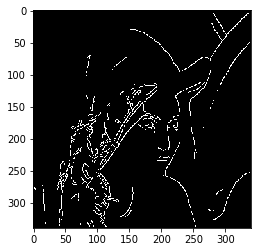

In [143]:
canny_final = DoThreshHyst(img_nms)
plt.imshow(canny_final, cmap = plt.get_cmap('gray'))
plt.show()

# Prewitt Edge Detector

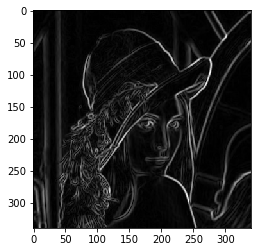

In [121]:
prewitt_img = ndimage.convolve(gray_img, mean_mask)
prewitt_dx = ndimage.convolve(prewitt_img, dx)
prewitt_dy = ndimage.convolve(prewitt_img, dy)
prewitt_res = np.hypot(prewitt_dx,prewitt_dy)
plt.imshow(prewitt_res, cmap = plt.get_cmap('gray'))
plt.show()

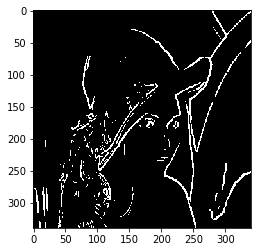

In [122]:
prewitt_res = Normalize(prewitt_res)
prewitt_final = applyThreshold(prewitt_res)
plt.imshow(prewitt_final, cmap = plt.get_cmap('gray'))
plt.show()

# Sobel Edge Detector

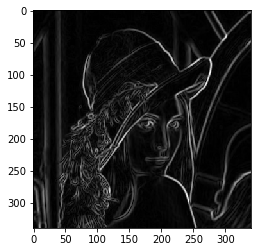

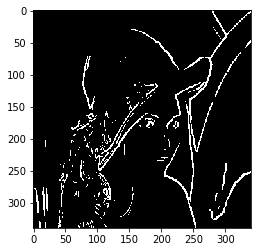

In [123]:
sobel_img = ndimage.convolve(gray_img, sobel_mask)
sobel_dx = ndimage.convolve(sobel_img, dx)
sobel_dy = ndimage.convolve(sobel_img, dy)
sobel_res = np.hypot(sobel_dx,sobel_dy)
plt.imshow(sobel_res, cmap = plt.get_cmap('gray'))
plt.show()
sobel_res = Normalize(sobel_res)
sobel_final = applyThreshold(sobel_res)
plt.imshow(sobel_final, cmap = plt.get_cmap('gray'))
plt.show()

# Marr Hildreth Edge Detector (Laplacian of Gaussian)

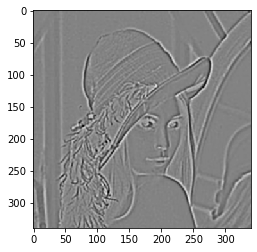

In [124]:
log_img = ndimage.gaussian_laplace(gray_img, 1.4) #laplacian of gaussian (log)
plt.imshow(log_img, cmap = plt.get_cmap('gray'))
plt.show()

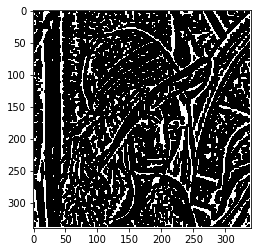

In [125]:
threshold =-0.05
log_final = np.ones(log_img.shape)
w,h = log_img.shape
for x in range(1,w-1):
    for y in range(1,h-1):
        window = log_img[x-1:x+2,y-1:y+2]
        point = log_img[x,y]
        wmax = window.max()
        wmin = window.min()
        if point==0.0 and wmax>0.0 and wmin<0.0:
            zeroCross=1
        elif point>0.0:
            zeroCross= True if wmin<0.0 else False
        else:
            zeroCross= True if wmin<0.0 else False
        if (wmax-wmin)>threshold and zeroCross:
            log_final[x,y] = 0

plt.imshow(log_final, cmap = plt.get_cmap('gray'))
plt.show()  